In [ ]:
from typing import List, Optional
import sys
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from scipy.spatial import cKDTree
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from hmmlearn.hmm import GaussianHMM
from scipy.spatial import cKDTree
from pathlib import Path

from main import dataloader, to_vect, Coordinates, calculate_asrs, classify_asrs


Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2022\trajectories_processed
Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2024\trajectories_processed


In [3]:
sample = next(iter(dataloader))
session = sample["patchy"]
if session is None:
    print("No session")
    sys.exit(1)
ZOOM_FACTOR = 1.5


def transform(coords: List[Coordinates], offset: np.ndarray, factor: float) -> np.ndarray:
    return (to_vect(coords) + offset) * factor


mushrooms_coords = session.mushroom_coords
mushrooms_coords = transform(mushrooms_coords, np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]
player_coords = transform([c["coord"] for c in session.player_coords], np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]

max_coord_x = int(mushrooms_coords[:, 0].max())
max_coord_z = int(mushrooms_coords[:, 1].max())

In [4]:
SESSION_TYPE = "patchy"

trajectories = []
for session in dataloader:
    if session[SESSION_TYPE] is not None:
        player_coords = transform([c["coord"] for c in session[SESSION_TYPE].player_coords], np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]
        trajectories.append(player_coords[:30000:25])

trajectories = np.array(trajectories)

In [5]:
def discretize_space(trajectories, n_states=100):
    """Convert continuous coordinates to discrete states using KMeans."""
    # Flatten all trajectories into one array of points
    all_points = np.vstack([traj for traj in trajectories])
    
    # Fit KMeans to find state centers
    kmeans = KMeans(n_clusters=n_states, random_state=42)
    kmeans.fit(all_points)
    
    # Convert each trajectory to sequence of state indices
    discrete_trajectories = []
    for traj in trajectories:
        states = kmeans.predict(traj)
        discrete_trajectories.append(states)
    
    return kmeans, np.array(discrete_trajectories)

kmeans, discrete_trajectories = discretize_space(trajectories, n_states=200)

In [35]:
def build_transition_matrix(discrete_trajectories, n_states):
    """Build Markov transition matrix from discrete trajectories."""
    transition_counts = np.zeros((n_states, n_states))
    
    # Count transitions between states
    for traj in discrete_trajectories:
        for i in range(len(traj) - 1):
            current_state = traj[i]
            next_state = traj[i + 1]
            transition_counts[current_state, next_state] += 1
    
    # Normalize to get probabilities
    transition_matrix = np.zeros_like(transition_counts)
    for i in range(n_states):
        row_sum = transition_counts[i].sum()
        if row_sum > 0:
            transition_matrix[i] = transition_counts[i] / row_sum
        else:
            # If no transitions from this state, use uniform distribution
            transition_matrix[i] = 1/n_states
    
    return transition_matrix

transition_matrix = build_transition_matrix(discrete_trajectories, n_states=200)

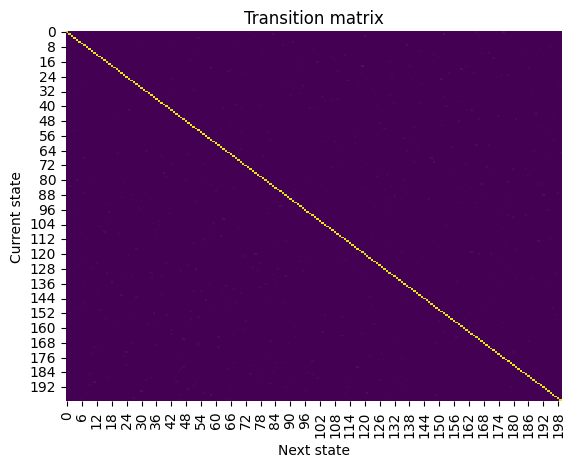

In [36]:
sns.heatmap(transition_matrix, cmap="viridis", cbar=False)
plt.title("Transition matrix")
plt.xlabel("Next state")
plt.ylabel("Current state")
plt.show()

In [ ]:
class HiddenMarkovModel:
    """
    Hidden Markov Model for trajectory modeling and generation.
    This model captures the dynamics of player movements across discrete states.
    """
    
    def __init__(self, n_states=100, random_state=42):
        """
        Initialize the Hidden Markov Model.
        
        Parameters:
        -----------
        n_states : int
            Number of discrete states to use for the model
        random_state : int
            Random seed for reproducibility
        """
        self.n_states = n_states
        self.random_state = random_state
        self.kmeans = None
        self.hmm = None
        self.fitted = False
        
    def fit(self, trajectories):
        """
        Fit the HMM to the provided trajectories.
        
        Parameters:
        -----------
        trajectories : List[np.ndarray]
            List of trajectory arrays, each with shape (n_points, 2) for x,z coordinates
        """
        print("Discretizing the state space...")
        self._fit_kmeans(trajectories)
        
        print("Training the Hidden Markov Model...")
        self._fit_hmm(trajectories)
        
        self.fitted = True
        print("Model fitting complete.")
            
    def _fit_kmeans(self, trajectories):
        """Fit KMeans to discretize the continuous state space"""
        # Combine all trajectory points
        all_points = np.vstack([traj for traj in trajectories])
        
        # Fit KMeans
        self.kmeans = KMeans(n_clusters=self.n_states, random_state=self.random_state)
        self.kmeans.fit(all_points)
        
    def _fit_hmm(self, trajectories):
        """Fit the Hidden Markov Model to discretized trajectories with proper regularization."""
        # Convert trajectories to state sequences
        discrete_trajectories = []
        lengths = []
        
        # Collect all points for covariance estimation
        all_points = np.vstack([traj for traj in trajectories if len(traj) > 0])
        
        for traj in trajectories:
            if len(traj) > 5:  # Need sufficient points for meaningful transitions
                # Get state assignments
                states = self.kmeans.predict(traj)
                discrete_trajectories.append(states)
                lengths.append(len(states))
        
        # Build initial transition matrix from data
        trans_mat = np.zeros((self.n_states, self.n_states))
        
        for states in discrete_trajectories:
            for i in range(len(states) - 1):
                trans_mat[states[i], states[i+1]] += 1
                
        # Add small pseudocount to ensure all states have transitions
        trans_mat = trans_mat + 0.1
                
        # Normalize rows
        row_sums = trans_mat.sum(axis=1)
        trans_mat = trans_mat / row_sums[:, np.newaxis]
        
        # Store this as a fallback
        self.transition_matrix = trans_mat.copy()
        self.state_centers = self.kmeans.cluster_centers_.copy()
        
        # Try fitting the HMM with careful initialization and regularization
        try:
            print("Initializing HMM...")
            
            # Prepare data for HMM - ensure we're working with sequences
            X = np.vstack(trajectories)
            X_lengths = [len(traj) for traj in trajectories]
            
            # Initialize HMM with careful parameters
            self.hmm = GaussianHMM(
                n_components=self.n_states,
                covariance_type="diag",  # Use diagonal covariance for stability
                n_iter=20,  # Limit iterations to avoid overfitting
                random_state=self.random_state,
                init_params="",  # Don't estimate parameters from data yet
                params="stmc"  # Estimate all parameters during fit
            )
            
            # Set strong initial parameters
            self.hmm.startprob_ = np.ones(self.n_states) / self.n_states
            self.hmm.transmat_ = trans_mat
            self.hmm.means_ = self.kmeans.cluster_centers_
            
            # Calculate diagonal covariance with regularization
            state_covs = np.zeros((self.n_states, 2))
            
            # Assign points to states and compute per-state covariance
            states = self.kmeans.predict(X)
            for i in range(self.n_states):
                state_points = X[states == i]
                if len(state_points) > 10:  # Only if we have enough points
                    state_covs[i] = np.var(state_points, axis=0)
                else:
                    # Fall back to global variance for sparse states
                    state_covs[i] = np.var(X, axis=0)
            
            # Ensure minimum variance and avoid exact zeros
            min_variance = 1.0
            state_covs = np.maximum(state_covs, min_variance)
            
            # Set covariance
            self.hmm.covars_ = state_covs
            
            print("Fitting HMM...")
            try:
                # Try regular fit first
                self.hmm.fit(X, X_lengths)
                print("HMM fitted successfully!")
            except Exception as e:
                print(f"Regular fit failed: {e}")
            
        except Exception as e:
            print(f"HMM fitting failed: {e}")
            print("Falling back to simple Markov Chain model")
            self.hmm = None  # Clear the HMM
        
    def generate_trajectory(self, length=1000, starting_state=None):
        """
        Generate a synthetic trajectory based on the trained model.
        
        Parameters:
        -----------
        length : int
            Length of the trajectory to generate
        starting_state : int, optional
            Starting state index, random if None
        
        Returns:
        --------
        np.ndarray
            Generated trajectory with shape (length, 2)
        list
            Sequence of states visited
        """
        if not self.fitted:
            raise ValueError("Model must be fitted before generating trajectories")
        
        # Choose random starting state if not provided
        if starting_state is None:
            starting_state = np.random.randint(0, self.n_states)
        
        # Initialize
        states = [starting_state]
        current_state = starting_state
        
        # Generate sequence of states using the transition matrix
        for _ in range(length - 1):
            # Get transition probabilities from current state
            probs = self.hmm.transmat_[current_state]
            
            # Sample next state
            next_state = np.random.choice(self.n_states, p=probs)
            states.append(next_state)
            current_state = next_state
        
        # Convert state sequence to coordinates
        trajectory = self.kmeans.cluster_centers_[states]
        
        # Add small random noise for more realistic paths
        noise = np.random.normal(0, 0.5, trajectory.shape)
        trajectory = trajectory + noise
        
        return trajectory, states
    
    def sample_trajectory(self, length=1000):
        """
        Sample a complete trajectory from the HMM including hidden states.
        This uses the HMM's built-in sample method.
        
        Parameters:
        -----------
        length : int
            Length of the trajectory to generate
            
        Returns:
        --------
        np.ndarray
            Generated trajectory with shape (length, 2)
        np.ndarray
            Hidden state sequence
        """
        if not self.fitted:
            raise ValueError("Model must be fitted before generating trajectories")
            
        # Sample from the HMM
        states, observations = self.hmm.sample(length)
        
        return observations, states
    
    def evaluate_coverage(self, generated_trajs, real_trajectories, grid_size=50):
        """
        Evaluate how well the generated trajectory covers the real data space.
        
        Parameters:
        -----------
        generated_traj : List[np.ndarray]
            List of generated trajectories
        real_trajectories : List[np.ndarray]
            List of real trajectories for comparison
        grid_size : int
            Resolution of the grid for coverage calculation
            
        Returns:
        --------
        dict
            Dictionary with coverage metrics
        """
        # Combine all real trajectory points
        all_real_points = np.vstack(real_trajectories)
        
        # Get bounds
        x_min, y_min = np.min(all_real_points, axis=0)
        x_max, y_max = np.max(all_real_points, axis=0)
        
        # Create occupancy grids
        real_grid = np.zeros((grid_size, grid_size))
        gen_grid = np.zeros((grid_size, grid_size))
        
        # Fill real grid
        for traj in real_trajectories:
            for x, y in traj:
                # Convert position to grid indices
                i = int((x - x_min) / (x_max - x_min) * (grid_size-1))
                j = int((y - y_min) / (y_max - y_min) * (grid_size-1))
                
                # Boundary check
                if 0 <= i < grid_size and 0 <= j < grid_size:
                    real_grid[i, j] = 1
        
        # Fill generated grid
        for traj in generated_trajs:
            for x, y in traj:
                # Convert position to grid indices
                i = int((x - x_min) / (x_max - x_min) * (grid_size-1))
                j = int((y - y_min) / (y_max - y_min) * (grid_size-1))
                
                # Boundary check
                if 0 <= i < grid_size and 0 <= j < grid_size:
                    gen_grid[i, j] = 1
        
        # Calculate metrics
        real_cells = np.sum(real_grid)
        gen_cells = np.sum(gen_grid)
        overlap_cells = np.sum(real_grid * gen_grid)
        
        coverage = overlap_cells / real_cells if real_cells > 0 else 0
        exploration = 1 - (overlap_cells / gen_cells if gen_cells > 0 else 0)
        
        return {
            "coverage": coverage,  # How much of real space is covered
            "exploration": exploration,  # How much exploration outside real space
            "overlap_cells": overlap_cells,
            "real_cells": real_cells,
            "gen_cells": gen_cells
        }
    
    def visualize(self, real_trajectories, generated_trajectories=None, n_real=5):
        """
        Visualize the model and generated trajectories.
        
        Parameters:
        -----------
        real_trajectories : List[np.ndarray]
            List of real trajectories
        generated_trajectories : List[np.ndarray], optional
            List of generated trajectories to display
        n_real : int
            Number of real trajectories to display
        """
        plt.figure(figsize=(12, 12))
        
        # Plot cluster centers
        plt.scatter(
            self.kmeans.cluster_centers_[:, 0], 
            self.kmeans.cluster_centers_[:, 1],
            c='gray', alpha=0.5, s=10, label='State centers'
        )
        
        # Plot strong transitions (optional)
        if self.hmm is not None:
            # Plot top transitions
            for i in range(self.n_states):
                for j in range(self.n_states):
                    # Only plot strong transitions
                    if self.hmm.transmat_[i, j] > 0.2:  
                        plt.arrow(
                            self.kmeans.cluster_centers_[i, 0],
                            self.kmeans.cluster_centers_[i, 1],
                            (self.kmeans.cluster_centers_[j, 0] - self.kmeans.cluster_centers_[i, 0]) * 0.8,
                            (self.kmeans.cluster_centers_[j, 1] - self.kmeans.cluster_centers_[i, 1]) * 0.8,
                            head_width=0.5, head_length=1, fc='blue', ec='blue', alpha=0.3
                        )
        
        plt.title('State Space and Transitions')
        plt.grid(True, alpha=0.3)
        
        # Plot sample of real trajectories
        import random
        sampled_real = random.sample(list(real_trajectories), min(n_real, len(real_trajectories)))
        
        for i, traj in enumerate(sampled_real):
            plt.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.3, linewidth=1)
            
        plt.plot([], [], 'b-', label='Real trajectories')  # For legend
            
        # Plot generated trajectories
        if generated_trajectories is not None:
            for i, traj in enumerate(np.array(generated_trajectories)):
                plt.plot(traj[:, 0], traj[:, 1], 'r-', alpha=0.8, linewidth=2)
                
            plt.plot([], [], 'r-', linewidth=2, label='Generated trajectories')  # For legend
        
        plt.title('Real vs. Generated Trajectories')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Plot transition matrix heatmap
        if self.hmm is not None:
            plt.figure(figsize=(10, 8))
            sns.heatmap(self.hmm.transmat_, cmap='viridis')
            plt.title('State Transition Matrix')
            plt.xlabel('To State')
            plt.ylabel('From State')
            plt.show()

hmm = HiddenMarkovModel(n_states=200)
hmm.fit(trajectories)

Discretizing the state space...
Training the Hidden Markov Model...
Initializing HMM...
Fitting HMM...
HMM fitted successfully!
Model fitting complete.


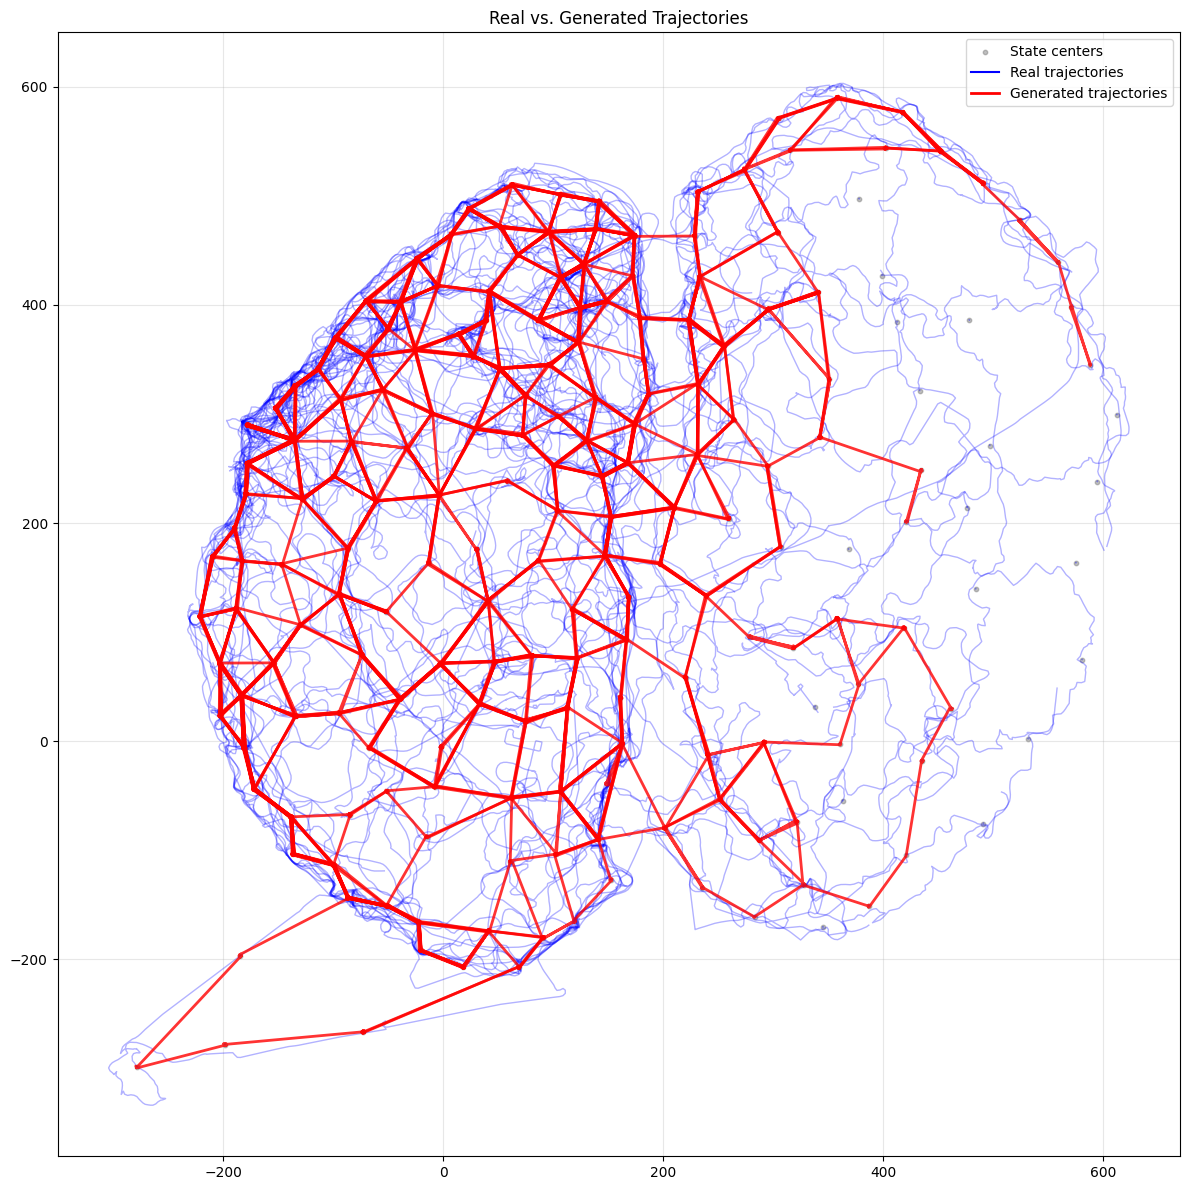

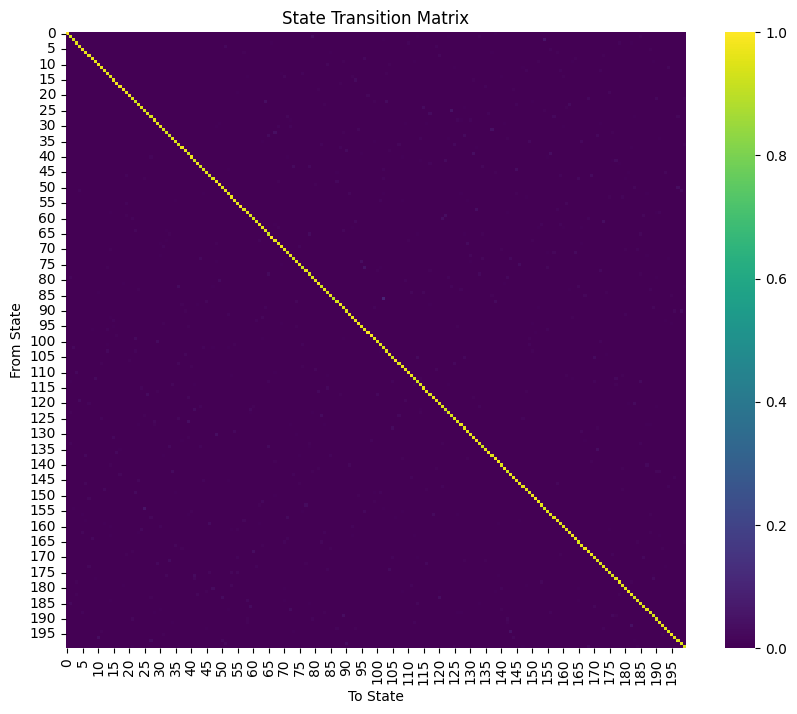

In [15]:
N_trajs = 38
generated_trajectories = [hmm.generate_trajectory(length=1200, starting_state=86)[0] for _ in range(N_trajs)]
hmm.visualize(trajectories, generated_trajectories, n_real=38)

In [21]:
def evaluate_coverage(generated_trajs, real_trajectories, grid_size=50):
        """
        Evaluate how well the generated trajectory covers the real data space.
        
        Parameters:
        -----------
        generated_traj : List[np.ndarray]
            List of generated trajectories
        real_trajectories : List[np.ndarray]
            List of real trajectories for comparison
        grid_size : int
            Resolution of the grid for coverage calculation
            
        Returns:
        --------
        dict
            Dictionary with coverage metrics
        """
        # Combine all real trajectory points
        all_real_points = np.vstack(real_trajectories)
        
        # Get bounds
        x_min, y_min = np.min(all_real_points, axis=0)
        x_max, y_max = np.max(all_real_points, axis=0)
        
        # Create occupancy grids
        real_grid = np.zeros((grid_size, grid_size))
        gen_grid = np.zeros((grid_size, grid_size))
        
        # Fill real grid
        for traj in real_trajectories:
            for x, y in traj:
                # Convert position to grid indices
                i = int((x - x_min) / (x_max - x_min) * (grid_size-1))
                j = int((y - y_min) / (y_max - y_min) * (grid_size-1))
                
                # Boundary check
                if 0 <= i < grid_size and 0 <= j < grid_size:
                    real_grid[i, j] = 1
        
        # Fill generated grid
        for traj in generated_trajs:
            for x, y in traj:
                # Convert position to grid indices
                i = int((x - x_min) / (x_max - x_min) * (grid_size-1))
                j = int((y - y_min) / (y_max - y_min) * (grid_size-1))
                
                # Boundary check
                if 0 <= i < grid_size and 0 <= j < grid_size:
                    gen_grid[i, j] = 1
        
        # Calculate metrics
        real_cells = np.sum(real_grid)
        gen_cells = np.sum(gen_grid)
        overlap_cells = np.sum(real_grid * gen_grid)
        
        coverage = overlap_cells / real_cells if real_cells > 0 else 0
        exploration = 1 - (overlap_cells / gen_cells if gen_cells > 0 else 0)
        
        return {
            "coverage": coverage,  # How much of real space is covered
            "exploration": exploration,  # How much exploration outside real space
            "overlap_cells": overlap_cells,
            "real_cells": real_cells,
            "gen_cells": gen_cells
        }



res = {
            "coverage": 0,  # How much of real space is covered
            "exploration": 0,  # How much exploration outside real space
            "overlap_cells": 0,
            "real_cells": 0,
            "gen_cells": 0
        }
for resolution in [50, 100, 200, 500, 1000]:
    print(f"Resolution: {resolution}")
    res = evaluate_coverage(generated_trajectories, trajectories, grid_size=resolution)
    print(res)

Resolution: 50
{'coverage': 0.1726147123088128, 'exploration': 0.008368200836820106, 'overlap_cells': 237.0, 'real_cells': 1373.0, 'gen_cells': 239.0}
Resolution: 100
{'coverage': 0.0651077487391105, 'exploration': 0.06885245901639347, 'overlap_cells': 284.0, 'real_cells': 4362.0, 'gen_cells': 305.0}
Resolution: 200
{'coverage': 0.02915277421561084, 'exploration': 0.1880952380952381, 'overlap_cells': 341.0, 'real_cells': 11697.0, 'gen_cells': 420.0}
Resolution: 500
{'coverage': 0.013475257615219114, 'exploration': 0.6076923076923078, 'overlap_cells': 357.0, 'real_cells': 26493.0, 'gen_cells': 910.0}
Resolution: 1000
{'coverage': 0.009356367527900932, 'exploration': 0.8478368970661363, 'overlap_cells': 306.0, 'real_cells': 32705.0, 'gen_cells': 2011.0}


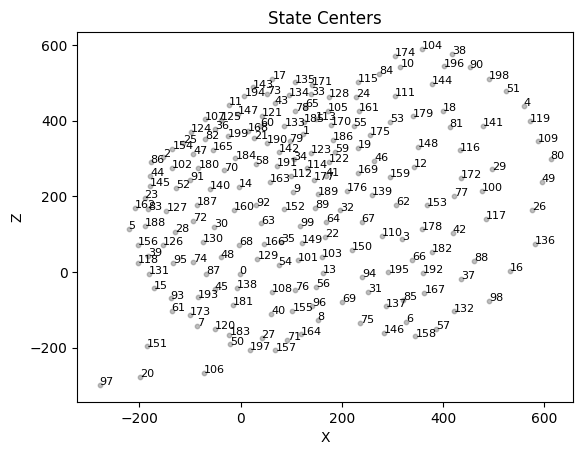

In [9]:
plt.scatter(hmm.state_centers[:, 0], hmm.state_centers[:, 1], c='gray', alpha=0.5, s=10)
# annotate states with ids
for i, (x, y) in enumerate(hmm.state_centers):
    plt.text(x, y, str(i), fontsize=8, color='black')
plt.title('State Centers')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()